In [7]:
from tensorflow.keras.models import load_model
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.backend as K
import keras
import os 
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.measurements import label

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.test.is_gpu_available())
print('-'*30)
print(tf.test.gpu_device_name())
print('-'*30)
print(tf.config.list_physical_devices('GPU'))
print('-'*30)
print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
------------------------------
/device:GPU:0
------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1281303024777305390
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10317004800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9372135219030433619
physical_device_desc: "device: 0, name: NVIDIA TITAN V, pci bus id: 0000:01:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [4]:
def load_segseg_model(model_seg_dir, weights_dir):
    json_file = open(model_seg_dir, 'r'); loaded_model_json = json_file.read(); json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(weights_dir) # Load model weights
    return model

def normalize_image(img,low_p=0,up_p=100):
    min_ = np.percentile(img.flatten(),low_p)
    max_ = np.percentile(img.flatten(),up_p)
    if min_ == max_ and max_ > 0:
        return (img - min_) / (max_ - min_)
    elif min_ == max_ and max_ == 0:
        return img
    else:
        new_img  = (img - min_) / (max_ - min_)
        new_img[new_img > 1] = 1
        new_img[new_img < 0] = 0

        return new_img

def process_mask(arr, out_shape):
    liv = arr[:,:,:,0]
    liv = zoom(liv, (out_shape[0]/192, out_shape[1]/192, out_shape[2]/96))
    liv[liv >= 0.5] = 1; liv[liv < 0.5] = 0
    liv = largestConnectedComponent(liv)
    arr_resize = np.zeros((out_shape[0], out_shape[1], out_shape[2], 10))
    for ii in range(arr.shape[-1]):
        arr_resize[:,:,:,ii] = zoom(arr[:,:,:,ii], (out_shape[0]/192, out_shape[1]/192, out_shape[2]/96))
    arr_resize[arr_resize <= 0.5] = 0.
    arr = np.argmax(np.concatenate([ np.zeros((out_shape[0], out_shape[1], out_shape[2],1)), arr_resize[:,:,:,1:] ], -1), axis=-1)
    arr_resize = np.zeros((out_shape[0], out_shape[1], out_shape[2], 9))
    for ii in range(9):
        arr_resize[:,:,:,ii][np.where(arr == (ii+1))] = 1
        arr_resize[:,:,:,ii] = largestConnectedComponent(arr_resize[:,:,:,ii])
    arr = np.argmax(np.concatenate([ np.zeros((out_shape[0], out_shape[1], out_shape[2],1)), arr_resize ], -1), axis=-1)
    return liv,arr

def largestConnectedComponent(cnn_seg):
    cnn_seg[cnn_seg >= 0.5] = 1; cnn_seg[cnn_seg < 0.5] = 0
    struct = np.ones((3,3,3))
    pred_postp1 = cnn_seg
    labels, num_features = label(pred_postp1,struct)
    if num_features !=0:
        feature_size = np.zeros((num_features,))
        for ii in range(num_features):
            feature_size[ii] = np.sum(labels==(ii+1))
            label_liver = np.argmax(feature_size)
            pred_postp = np.zeros(cnn_seg.shape)
            pred_postp[labels== (label_liver+1)] = 1
    else:
        pred_postp = cnn_seg
    return pred_postp

In [5]:
model_dir = 'segmental_segmentation_model.hdf5' 
weight_dir = 'segmental_segmentation_weights.hdf5' 

model = load_segseg_model(model_dir, weight_dir)

In [97]:
case_id = 'c_9122.nii'

parent_dir = r'N:\2_Analysis\automated_analysis\cynch_segmentations\cynch_additions\mag_ni/'

mag_dir = os.path.join(parent_dir, case_id)

In [98]:
mag_ni = nib.load(mag_dir)

mag = normalize_image(mag_ni.get_fdata())

echo0 = np.flip(np.rot90(mag), 1)

In [99]:
echo0.shape, echo0.min(), echo0.max()

((224, 224, 27), 0.0, 1.0)

In [100]:
test_slice = echo0[:,:,15]

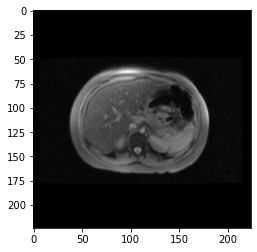

((224, 224), 0.0, 0.909667446019236)

In [101]:
plt.imshow(test_slice,cmap='gray')
plt.show()
test_slice.shape, test_slice.min(), test_slice.max()

In [102]:
s0,s1,s2 = echo0.shape
inp = zoom(echo0, (192/s0,192/s1,96/s2))
inp = np.expand_dims(np.expand_dims(normalize_image(inp, 0, 95), 0), -1)

pred = model.predict(inp)[0]

liver,seg = process_mask(pred, echo0.shape)

liver = liver.astype('int8')

In [103]:
liver = np.swapaxes(liver,0,1)
liver = np.flip(liver,0)
liver = np.flip(liver,1)

In [104]:
output = r'N:\2_Analysis\automated_analysis\cynch_segmentations\cynch_additions\whole_liver_seg/'

new = nib.Nifti1Image(liver, mag_ni.affine)
nib.save(new, os.path.join(output, case_id))